## Fetch weather data

### Notebook Purpose:

- It might be worth to a point in time weather statistics to generate more accurate forecast
- Dark Sky provides a nice API with first 1000 calls for free, and then 0.0001 cent per request

In [216]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


#### Load libraries

In [1]:
import requests
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
from datetime import datetime
from tqdm import tqdm

#### Collect data from DarkSky API

In [2]:
def make_ts(year, month, day, hour, minute=0, second=0):
    return int(datetime(year, month, day, hour, minute, second).timestamp())

In [6]:
# define API parameters
BASE_URL = 'https://api.darksky.net/forecast'
API_KEY = '3d8137be1b3eb40d88ba1793e47f7071'
lat = 51.802931199999996
long = -8.302591999999999
timestamp = make_ts(2020, 1, 4, 15, 10)
headers = {'Accept-Encoding': 'gzip'}

In [4]:
# define keys to pull from the API data
cur_keys = map(str.strip, """summary, precipIntensity, precipProbability, precipType, temperature, apparentTemperature, humidity,
windSpeed, windGust, windBearing, cloudCover, uvIndex, visibility""".split(','))
cur_keys = [k for k in cur_keys]
daily_keys = map(str.strip, """summary, sunriseTime, sunsetTime, temperatureHigh, temperatureLow""".split(','))
daily_keys = [k for k in daily_keys]

#### Define date range for data pull

In [12]:
idx = pd.date_range(start='2019-12-27 00:30:00', end='2020-03-02 23:59:00', freq='1H')
df = pd.DataFrame({'dt': idx})

#### Pull data

In [13]:
def make_url(ts):
    return f'{BASE_URL}/{API_KEY}/{lat},{long},{ts}?exclude=hourly,flags,minutely&units=ca'

dark_sky = []
prev_cur_obj = {}
prev_daily_obj = {}

for index, d in tqdm(df.iterrows(), total=df.shape[0]):
    
    # extract date-time info from dt object
    args = (d.dt.year, d.dt.month, d.dt.day, d.dt.hour, d.dt.minute)
    ts = make_ts(*args)
    
    # make a call to Dark Sky API
    url = make_url(ts)
    sky_data = requests.get(url, headers=headers)
    sky_data = sky_data.json()
    currently = sky_data['currently']
    daily = sky_data['daily']
    
    # init object to save
    cur_obj = {'ts': ts, 'dt': d}
    
    # keep only selected data elements
    for k in cur_keys:
        if k in currently:
            cur_obj[f'cur__{k}'] = currently[k]
            prev_cur_obj[k] = currently[k]
        else:
            cur_obj[f'cur__{k}'] = prev_cur_obj[k]
        
    for k in daily_keys:
        if k in daily['data'][0]:
            cur_obj[f'daily__{k}'] = daily['data'][0][k]
            prev_daily_obj[k] = daily['data'][0][k]
        else:
            cur_obj[f'daily__{k}'] = prev_daily_obj[k]
    dark_sky.append(cur_obj)
    
dark_sky_df = pd.DataFrame(dark_sky)
dark_sky_df['dt'] = df['dt']
dark_sky_df.to_csv('../Datasets/dark_sky_data_2019-12-27_2020-03-02.csv', index=False)

100%|██████████| 1608/1608 [39:24<00:00,  1.47s/it] 


#### Quick sanity check over the data

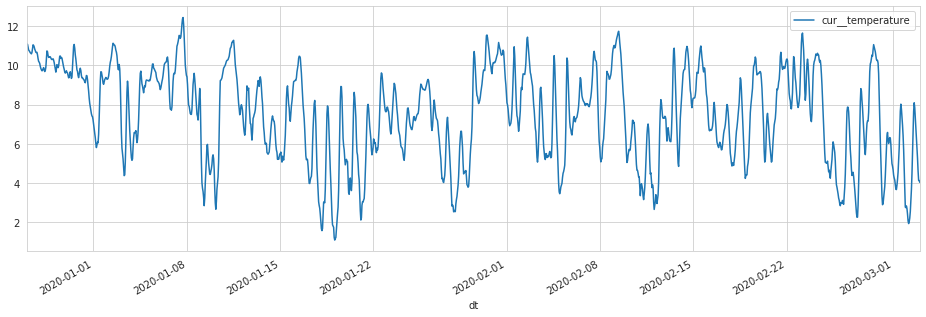

In [14]:
dark_sky_df.set_index('dt')[['cur__temperature']].plot(figsize=(16, 5));